<a href="https://colab.research.google.com/github/LuluW8071/Text-Classification/blob/main/Text_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Download and Load the dataset

In [158]:
import gdown
import zipfile
import os

file_url = 'https://drive.google.com/uc?id=1dUU9NX9sotEJ5DpUwdYhfh3pQqqjUJa-'
file_name = 'sentiment_dataset.zip'

# Download the file from Google Drive
gdown.download(file_url, file_name, quiet=False)
extract_dir = './dataset'

# Extract the zip file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Remove the zip file after extraction
os.remove(file_name)
print("Files extracted successfully to:", extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1dUU9NX9sotEJ5DpUwdYhfh3pQqqjUJa-
From (redirected): https://drive.google.com/uc?id=1dUU9NX9sotEJ5DpUwdYhfh3pQqqjUJa-&confirm=t&uuid=4c949a0f-e7dd-4b8c-a7bf-578116c00e25
To: /content/sentiment_dataset.zip
100%|██████████| 26.3M/26.3M [00:00<00:00, 30.4MB/s]


Files extracted successfully to: ./dataset


In [159]:
import pandas as pd
import numpy as np

In [160]:
df = pd.read_csv("dataset/IMDB Dataset.csv")
df.sample(5)

,review,sentiment
2719,Wow! After the first five minutes of watching ...,negative
8165,Another slice of darkness and denial hiding be...,positive
23496,The story is a little slow and a little stupid...,negative
47482,I can envision the writers of this story think...,negative
24669,Here's another of the 1940's westerns that I w...,positive


## 2. Data Analysis

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

train data shape: (40000,)
test data shape: (10000,)


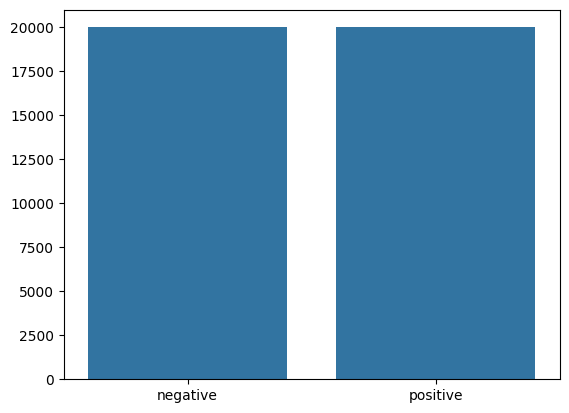

In [162]:
X, y = df['review'].values,df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    stratify = y)
print(f'train data shape: {X_train.shape}')
print(f'test data shape: {X_test.shape}')


val = pd.Series(y_train).value_counts()
sns.barplot(x = np.array(['negative','positive']),
            y = val.values)
plt.show()

## 3. Text Pre-Processing
- Cleaning up the text data by removing punctuation, extra spaces, and numbers.
- Transform sentences into individual words, remove common words (known as "stop words")
- Keeping track of the 1000 most frequently used words in the dataset
- Assigning tracked words a unique identifier, forming dictionary for one-hot encoding
- Ensuring all sequences have the same length by padding or truncating them as needed by 500 tokens

In [163]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [164]:
# Cleaning text function
def preprocess_string(s):
  # Remove all non-word characters (everything except numbers and letters)
  s = re.sub(r"[^\w\s]", '', s)
  # Replace all runs of whitespaces with no space
  s = re.sub(r"\s+", ' ', s)
  # Replace digits with no space
  s = re.sub(r"\d", '', s)
  # Replace usernames with no space
  s = re.sub(r"@([^\s]+)", '', s)
  # Replace hashtags with numbers with no space
  s = re.sub(r"#\d+", '', s)
  # Replace specific characters
  s = s.replace("https", "")
  s = s.replace("http", "")
  s = s.replace("rt", "")
  s = s.replace("-", "")
  # Replace <br /> with a space
  s = s.replace("<br />", " ")
  return s

In [165]:
# Create a Tokenize including  padding Function
def tokenize(X_train, y_train, X_val, y_val, seq_len):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in tqdm(X_train, desc="Preprocessing train data"):
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)

    # sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w: i + 1 for i, w in enumerate(corpus_)}

    # tokenize and pad sequences
    final_list_train, final_list_test = [], []
    for sent in tqdm(X_train, desc="Tokenizing and padding train data"):
        tokens = [onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                  if preprocess_string(word) in onehot_dict.keys()]
        padded_tokens = tokens[-seq_len:] if len(tokens) > seq_len else [0] * (seq_len - len(tokens)) + tokens
        final_list_train.append(padded_tokens)

    for sent in tqdm(X_val, desc="Tokenizing and padding validation data"):
        tokens = [onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                  if preprocess_string(word) in onehot_dict.keys()]
        padded_tokens = tokens[-seq_len:] if len(tokens) > seq_len else [0] * (seq_len - len(tokens)) + tokens
        final_list_test.append(padded_tokens)

    encoded_train = [1 if label == 'positive' else 0 for label in y_train]
    encoded_test = [1 if label == 'positive' else 0 for label in y_val]

    return np.array(final_list_train), np.array(encoded_train), np.array(final_list_test), np.array(encoded_test), onehot_dict

In [166]:
seq_len = 350
X_train, y_train, X_test, y_test, vocab = tokenize(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   seq_len)

len(X_train), len(X_test)

Tokenizing and padding validation data: 100%|██████████| 10000/10000 [00:22<00:00, 449.64it/s]


(40000, 10000)

In [167]:
X_train, y_train

(array([[  0,   0,   0, ..., 638, 141,   4],
        [  0,   0,   0, ...,  21,  25,   4],
        [  0,   0,   0, ...,  21,   1,  40],
        ...,
        [  0,   0,   0, ..., 855, 326,   2],
        [  0,   0,   0, ..., 146,  36, 204],
        [  0,   0,   0, ...,  73, 121,  12]]),
 array([0, 0, 1, ..., 1, 1, 1]))

## 4. Preparing the data using DataLoader

In [168]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [169]:
# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train),
                           torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_test),
                           torch.from_numpy(y_test))

BATCH_SIZE = 50

# Create train and valid dataloader
train_dataloader = DataLoader(train_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)

len(train_dataloader), len(valid_dataloader)

(800, 200)

In [170]:
# Sampling one bacth from train_dataloader
sample_data = iter(train_dataloader)
sample_x, sample_y = next(sample_data)

print('Sample input size:', sample_x.size())     # batch_size, seq_length
print('Sample input:', sample_x)
print('Sample output:', sample_y)

Sample input size: torch.Size([50, 350])
Sample input: tensor([[  0,   0,   0,  ..., 678,  11,   1],
        [  0,   0,   0,  ..., 654, 309, 412],
        [  0,   0,   0,  ...,  66, 329, 910],
        ...,
        [  0,   0,   0,  ...,  55, 733,  47],
        [  0,   0,   0,  ...,   2,  32, 190],
        [  0,   0,   0,  ..., 784,   6,   3]])
Sample output: tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1])


## 5. Building a LSTM Model

In [171]:
import torch
from torch import nn
from torch.nn.utils import clip_grad_norm_

# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [172]:
class SentimentLSTM(nn.Module):
  def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim = 1):
    super(SentimentLSTM, self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size

    # Embedding and LSTM layers
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM Layer
    self.lstm = nn.LSTM(input_size = embedding_dim,
                        hidden_size = self.hidden_dim,
                        num_layers = no_layers,
                        batch_first = True)

    self.dropout = nn.Dropout(0.3)                    # Dropout Layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)  # Linear Layer
    self.sig = nn.Sigmoid()                           # Sigmoid Activation Function

  def forward(self, x, hidden):
    """ Forward pass """
    batch_size = x.size(0)

    # Embeddings and lstm_out
    embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
    # print(embeds.shape)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

    out = self.dropout(lstm_out)            # Dropout
    out = self.fc(out)                      # Fully connected layer

    sig_out = self.sig(out)                 # sigmoid function
    sig_out = sig_out.view(batch_size, -1)  # Reshape to be batch_size first
    sig_out = sig_out[:, -1]                # get last batch of labels
    return sig_out, hidden                  # return last sigmoid output and hidden state

  def init_hidden(self, batch_size):
    """ Initializes hidden state """
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # Initialized to zero, for hidden state and cell state of LSTM
    hidden_state = torch.zeros((self.no_layers,
                                batch_size,
                                self.hidden_dim)).to(device)
    # print(batch_size)
    cell_state = torch.zeros((self.no_layers,
                              batch_size,
                              self.hidden_dim)).to(device)
    hidden = (hidden_state, cell_state)
    # print("Hidden", hidden_state.size())
    # print("Cell", cell_state.size())
    return hidden

In [173]:
model = SentimentLSTM(no_layers = 2,               # LSTM doesn't perform quite well beyound 2 layers
                      vocab_size = len(vocab) + 1, # 1 extra for padding
                      hidden_dim = 256,
                      embedding_dim = 64)

# Pass model to device 'cuda' if selected
model.to(device)

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

## 6. Create Train and Validation Loop Function

In [174]:
# Function to predict accuracy
def acc(pred, label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

In [175]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs, clip, device):
  valid_loss_min = np.Inf
  epoch_tr_loss, epoch_vl_loss = [], []
  epoch_tr_acc, epoch_vl_acc = [], []

  for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    # Initialize hidden state
    h = model.init_hidden(BATCH_SIZE)

    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      # Creating new variables for the hidden state to prevent backpropagation
      # through the entire training history
      h = tuple([each.data for each in h])

      optimizer.zero_grad()
      output, h = model(inputs, h)
      loss = criterion(output.squeeze(), labels.float())
      loss.backward()

      train_losses.append(loss.item())
      accuracy = acc(output, labels)
      train_acc += accuracy
      clip_grad_norm_(model.parameters(), clip)
      optimizer.step()

    val_h = model.init_hidden(BATCH_SIZE)
    val_losses = []
    val_acc = 0.0
    model.eval()

    for inputs, labels in valid_loader:
      val_h = tuple([each.data for each in val_h])
      inputs, labels = inputs.to(device), labels.to(device)
      output, val_h = model(inputs, val_h)
      val_loss = criterion(output.squeeze(), labels.float())
      val_losses.append(val_loss.item())
      accuracy = acc(output, labels)
      val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch: {epoch+1} -- train_loss: {epoch_train_loss:.4f} -- train_acc: {epoch_train_acc*100:.2f}% -- val_loss: {epoch_val_loss:.4f} -- val_acc: {epoch_val_acc*100:.2f}%')

    # Saving model on each epoch except when valid_loss_for_next_epoch > valid_loss_for_prev_epoch
    if epoch_val_loss <= valid_loss_min:
      torch.save(model.state_dict(), 'sentiment_model.pth')
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
      valid_loss_min = epoch_val_loss
    print(25*'==')

  return epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc

## 7. Train and Evaluate the Model

In [176]:
# Loss function and Optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [177]:
train_losses, val_losses, train_accs, val_accs = train_model(model = model,
                                                             train_loader = train_dataloader,
                                                             valid_loader = valid_dataloader,
                                                             criterion = loss_fn,
                                                             optimizer = optimizer,
                                                             epochs = 6,
                                                             clip = 5,
                                                             device = device)

Epoch: 1 -- train_loss: 0.5307 -- train_acc: 74.36% -- val_loss: 0.4336 -- val_acc: 82.03%
Validation loss decreased (inf --> 0.433642).  Saving model ...
Epoch: 2 -- train_loss: 0.3893 -- train_acc: 83.37% -- val_loss: 0.3546 -- val_acc: 84.99%
Validation loss decreased (0.433642 --> 0.354614).  Saving model ...
Epoch: 3 -- train_loss: 0.3327 -- train_acc: 85.75% -- val_loss: 0.3416 -- val_acc: 85.60%
Validation loss decreased (0.354614 --> 0.341645).  Saving model ...
Epoch: 4 -- train_loss: 0.3087 -- train_acc: 87.03% -- val_loss: 0.3335 -- val_acc: 85.41%
Validation loss decreased (0.341645 --> 0.333542).  Saving model ...
Epoch: 5 -- train_loss: 0.2782 -- train_acc: 88.56% -- val_loss: 0.3424 -- val_acc: 85.36%
Epoch: 6 -- train_loss: 0.2405 -- train_acc: 90.33% -- val_loss: 0.3536 -- val_acc: 85.93%


## 8. Plot Loss and Accuracy Curves

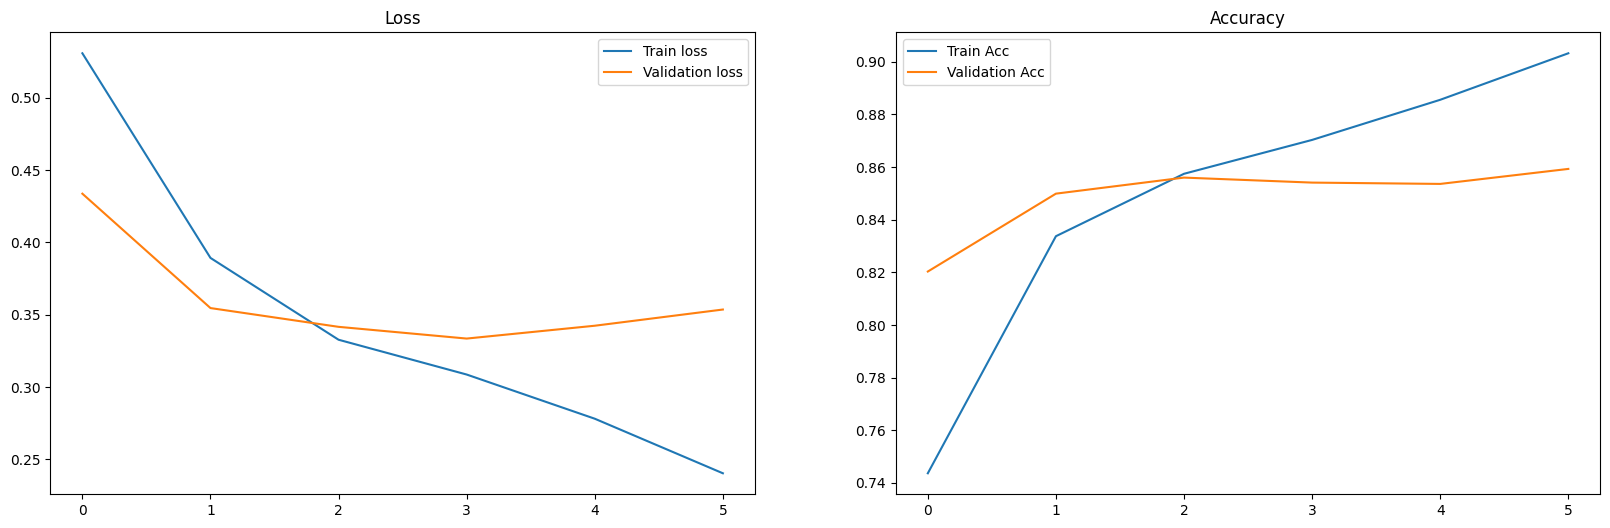

In [178]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Validation Acc')
plt.title("Accuracy")
plt.legend()

plt.show()

## 9. Load Model to `cpu`

In [179]:
# Load model configs
model = SentimentLSTM(no_layers = 2,
                      vocab_size = len(vocab) + 1,
                      hidden_dim = 256,
                      embedding_dim = 64)

# Load the model state dict
model.load_state_dict(torch.load("sentiment_model.pth", map_location=device))

# Move the model to CPU
model.to('cpu')

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

## 10. Make Prediction using Loaded Model

In [281]:
def padding_(seq, max_length):
    """Pad sequences to the same length."""
    if len(seq) >= max_length:
        return seq[:max_length]
    else:
        padded = np.zeros((seq.shape[0], max_length), dtype=int)
        padded[:, :seq.shape[1]] = seq
        return padded

def predict_text(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq, axis=0)
    pad = torch.from_numpy(padding_(word_seq, 350))
    inputs = pad.to('cpu')  # Move inputs to CPU
    batch_size = 1
    h = model.init_hidden(batch_size)
    # Move the initial hidden state to CPU
    h = tuple([each.to('cpu') for each in h])
    # Set to evaluation mode
    with torch.inference_mode():
        output, h = model(inputs, h)
    return output.item()

In [282]:
import random

# Randomly select 5 index from dataset to predict
for _ in range(5):
    index = random.randint(0, 50000)
    review = df['review'][index]
    actual_sentiment = df['sentiment'][index]

    print("Review:")
    print(review)
    print('='*70)
    print(f'Actual sentiment: {actual_sentiment}')
    print('='*70)
    pro = predict_text(review)
    predicted_sentiment = "positive" if pro > 0.5 else "negative"
    pro = (1 - pro) if predicted_sentiment == "negative" else pro

    # Color-coding output based on prediction matching actual sentiment
    if actual_sentiment == predicted_sentiment:
        color = '\033[92m'  # Green color for matching sentiment
    else:
        color = '\033[91m'  # Red color for mismatching sentiment

    print(f'Predicted sentiment: {color}{predicted_sentiment}\033[0m with a probability of {pro * 100:.2f}%')
    print('='*70)

Review:
I say sadly because if you see this movie now, you realize how low our media has sunk- all the warning signs are in this movie.<br /><br />It's a great film, I think the last great James Brooks film, but others may disagree. It has rich characters (who are believable as well), great acting, great writing, and although the music got a little cheesy, I even liked that.<br /><br />William Hurt has never been better. Holly Hunter is stunning. And Albert Brooks walks away with every scene he's in- this triangle of people is beautifully drawn and compelling and made the whole movie soar above it's vital and important topic of the News, and how it's slowly being compromised in our nation.<br /><br />Watch this with NETWORK for a truly fun and frightening evening.
Actual sentiment: positive
Predicted sentiment: negative with a probability of 52.79%
Review:
The visuals and effects are up to par with the the original film and provide a lot of entertainment even if the storyline is essent

In [299]:
def predict_custom_text(custom_text):
  pro = predict_text(custom_text)
  status = "positive" if pro > 0.5 else "negative"
  pro = (1 - pro) if status == "negative" else pro
  print(f'Predicted: {status} \nProbability {pro*100 :.2f}%')

In [300]:
# Custom Negative Text
custom_text = "I can't even begin to express my sheer frustration and utter disappointment with this product! It's an absolute disaster from start to finish. "
predict_custom_text(custom_text)

Predicted: negative 
Probability 56.25%


In [301]:
# Custom Positive Text
custom_text = "I recently watched a movie that completely exceeded my expectations. From the captivating storyline to the stellar performances of the cast, every aspect of the film was a delight. The characters were well-developed and relatable, each with their own unique charm that drew me into their world. The dialogue was witty and engaging, keeping me entertained from start to finish. Additionally, the stunning visuals and masterful cinematography added depth and richness to the viewing experience. Overall, it was a cinematic masterpiece that left me feeling uplifted and inspired. I highly recommend this movie to anyone looking for a heartwarming and enjoyable film."
predict_custom_text(custom_text)

Predicted: positive 
Probability 51.15%
